In [2]:
import numpy as np
from stl import mesh
import matplotlib.pyplot as plt
import time
import pyvista
import itertools
import tqdm as tqdm
from sklearn.neighbors import NearestNeighbors


In [3]:
#fp = "../../real_data/02_GrotteDeLaCascadeDeMotiers/output/3rdGallery_cropped_not_filled_25cm.stl"

fp = "../../real_data/17_Hoelloch/KellerAquarium/output/KellerAquarium_20cm.stl"


#fp = "../../sample_data/SampleCave/output/CylinderMesh.stl"
my_mesh = mesh.Mesh.from_file(fp)

I use the numpy-stl library to real the file to an stl.Mesh object

The data attribute gives a data-array containing each triangle entry.
The 0th index is the normal, the 1st index a triplet of coordinates, the 2nd index is an attribute.

In [4]:
my_mesh.data.shape

(202186,)

The vectors attribute returns the array of triangle vertex coordinates.

In [5]:
my_mesh.vectors.shape

(202186, 3, 3)

The normals attribute returns the array of triangle normals.

In [6]:
my_mesh.normals.shape

(202186, 3)

Now we want to find every edge-neighbour for each triangle (this may be two or three).

In [7]:
def find_neighbours_with_knn(theMesh):
    """
    extracts a n x 3 matrix of neighbouring triangle indices given a meshed surface containing n triangle.
    """
    time_in = time.time()

    # set up a nearest neighbour search.
    knn = NearestNeighbors(n_neighbors=12)
    knn.fit(theMesh.centroids)
    distances, indices = knn.kneighbors(theMesh.centroids)
    
    vectors = theMesh.vectors
    
    # allow for different combinations of vertices by using np.roll on the cartesian coordinate triplet.
    combi_vectors = np.vstack([vectors, np.roll(vectors, 1, axis =1), np.roll(vectors, 2, axis =1)]).reshape((3,*vectors.shape))

    # initialise the indices of neighbouring triangles.
    adjacent_triangles = -999*np.ones((vectors.shape[0],3), dtype=int)
    
    for c, triangle_indices in enumerate(indices):
        combi_vec = combi_vectors[:,triangle_indices]
        orig_triangle = vectors[c]
    
        sharing_vertices = np.argwhere(np.alltrue(np.equal(orig_triangle,combi_vec), axis=3))[:,1]
        
        k = 0
        for i in np.unique(sharing_vertices):
            if np.argwhere(sharing_vertices==i).shape[0] == 2 and k < 3:
                #print(f"this index appears {i}, corresponding to triangle {triangle_indices[i]} appears")
                adjacent_triangles[c, k] = triangle_indices[i] 
                k+=1
    time_out = time.time()
    
    print(f"knn search complete and neighbouring triangles found in {time_out - time_in:.4f}s ({vectors.shape[0]} triangle neighbour sets.)")
    
    return adjacent_triangles
    

In [8]:
adj_triangles = find_neighbours_with_knn(my_mesh)

knn search complete and neighbouring triangles found in 10.2706s (202186 triangle neighbour sets.)


In [9]:
np.savetxt("../../real_data/17_Hoelloch/KellerAquarium/output/KellerAquarium_20cm_adj_triangles.txt", adj_triangles)

What we now need is the array of uniquely indexed points. 

In [9]:
def levi_cevita_tensor(dim):   
    arr=np.zeros(tuple([dim for _ in range(dim)]))
    for x in itertools.permutations(tuple(range(dim))):
        mat = np.zeros((dim, dim), dtype=np.int32)
        for i, j in zip(range(dim), x):
            mat[i, j] = 1
        arr[x]=int(np.linalg.det(mat))
    return arr    

eps = levi_cevita_tensor(3)

In [10]:
def rotate(u, theta):
    """
    returns the rotation matrix given an direction u and an angle theta.
    """
    costh = np.cos(theta)
    sinth = np.sin(theta)
    
    ux = u[0]
    uy = u[1]
    uz = u[2]
    R0 = [costh+ux**2*(1-costh), ux*uy*(1-costh)-uz*sinth, ux*uz*(1-costh)+ux*sinth]
    R1 = [uy*ux*(1-costh)+uz*sinth,costh+uy**2*(1-costh), uy*uz*(1-costh)-ux*sinth]
    R2 = [uz*ux*(1-costh)+uy*sinth, uz*uy*(1-costh)+ux*sinth, costh+uz**2*(1-costh)]
    
    R = [R0, R1, R2]
    
    return R

In [11]:
R = rotate(np.array([0, 0, 1]), -np.pi /2)

In [12]:
nP = np.array([1, 0, 0])

In [13]:
R @ nP

array([ 6.123234e-17, -1.000000e+00,  0.000000e+00])

In [14]:
def intersect(theMesh,adj_triangles, P, nP0):
    
    # define the plane of section by a point and its normal. 
    nP = nP0

    vectors = theMesh.vectors
    normals = theMesh.normals

    # calculate the dot product of each triangle vertex to the plane of section: distance plane to vertex.
    PT_i_k = (P - vectors) @ nP

    # find all triangles  where there are opposite signs for the distance to plane. They are intersected.
    all_pos = np.all(np.equal(PT_i_k, np.abs(PT_i_k)), axis = 1)
    all_neg = np.all(np.equal(-PT_i_k, np.abs(PT_i_k)), axis = 1)

    # find all the triangles containing quantities PT_i_k of opposite signs. 
    intersected_triangles = np.argwhere(~(all_neg | all_pos))
    
    # make a mutable list of unvisited triangles
    intersected_triangles_list = [elem[0] for elem in intersected_triangles]

    n = len(intersected_triangles_list) # number of triangles to visit
    i = 0 # starting index for the triangles to visit
    triangle_counter = 0 # triangle visited counter

    # initialisation of segment middle points, segment edges, facet normals, W and area.
    M = np.zeros((n, 3))
    M1M2 = np.zeros((n, 3))
    PM1M2 = np.zeros((n+1,3))
    nOmega = np.zeros((n, 3))
    W = np.zeros(3)
    area = 0

    T0 = np.zeros((3, 3))
    
    while triangle_counter < n: # stop when all triangles have been visited
        
        triangle_idx = intersected_triangles[i][0] # the index of the triangle relative to mesh indexation


        
        PT_k = PT_i_k[triangle_idx]
    
        # triplet of vector coordinates
        T = vectors[triangle_idx]
        norm = normals[triangle_idx]
    
        # label the summit alone in the half space with 0. # relabelling by rolling. Doing the same to the triangles. 
        if PT_k[1] * PT_k[2] < 0 and PT_k[0] * PT_k[1] < 0: 
            PT_k = np.roll(PT_k, 2)
            T = np.roll(T, 2, axis = 0)
        elif PT_k[1] * PT_k[2] < 0 and PT_k[0] * PT_k[1] > 0:
            PT_k = np.roll(PT_k, 1)
            T = np.roll(T,1, axis = 0)
        
        # the 0th label must be the point which is in one of the half spaces. 
        assert PT_k[1] * PT_k[2] > 0

        alpha_i1 = PT_k[0] / (PT_k[0]-PT_k[1])
        alpha_i2 = PT_k[0] / (PT_k[0]-PT_k[2])

        # segment M_i1M_i2
        M_i1M_i2 = alpha_i2*(T[0] -T[2]) - alpha_i1*(T[0] -T[1])

        # intersection of the plane with segment T_i0T_i1
        M_i1 = T[0]- alpha_i1*(T[0] -T[1])
        # intersection of the plane with segment T_i0T_i2
        M_i2 = T[0]- alpha_i2*(T[0] -T[2])

        # coordinates of the middle point of segment M_i1M_i2
        M_i = M_i1-0.5 * M_i1M_i2

        # update the arrays
        M[triangle_counter] = M_i
        nOmega[triangle_counter] = norm

        # check whether there is a flipped vector or not.
        if triangle_counter == 0:
            PM1M2[0] = M_i1
            PM1M2[1] = M_i2

        elif triangle_counter == 1:
           
            # check whether the previous point is the same as 1st or 2nd index.
            if np.allclose(M_i1, PM1M2[triangle_counter]) or np.allclose(M_i2, PM1M2[triangle_counter]):
                if np.allclose(M_i1, PM1M2[triangle_counter]):
                    PM1M2[triangle_counter+1] = M_i2
                else:
                    PM1M2[triangle_counter+1] = M_i1
                    
            elif np.allclose(M_i1, PM1M2[triangle_counter-1]) or np.allclose(M_i2, PM1M2[triangle_counter-1]):
                # we have to switch the first two.
                PM1M2[:2] = PM1M2.copy()[[1,0]]
                
                if np.allclose(M_i1, PM1M2[triangle_counter]):
                    PM1M2[triangle_counter+1] = M_i2
                else:
                    PM1M2[triangle_counter+1] = M_i1
            
            else:
                print("this might be invalid")
                if np.logical_not(np.all(np.equal(PM1M2[triangle_counter],M_i1))):
                    PM1M2[triangle_counter+1] = M_i1
                else:
                    PM1M2[triangle_counter+1] = M_i2
                    
        else:
            
            # check whether the previous point is the same as 1st index.
            if np.allclose(M_i1, PM1M2[triangle_counter]):
                PM1M2[triangle_counter+1] = M_i2
            
            elif np.allclose(M_i2, PM1M2[triangle_counter]):
                PM1M2[triangle_counter+1] = M_i1

        
            
        M1M2[triangle_counter] = PM1M2[triangle_counter+1] - PM1M2[triangle_counter]

        area += np.linalg.det(np.array([M1M2[triangle_counter], M[triangle_counter]-P, nP])) / 2
        
        # increment the W vector. 
        
        for m in range(3):
            num = 0
            Wi_m = []
            for j in range(3):
                for k in range(3):
                    num+= eps[m,j,k]*(M[triangle_counter]-P)[j]*nOmega[triangle_counter,k]
                    
            denom = (M[triangle_counter] - P) @ nOmega[triangle_counter]
            
            #print(np.array([M1M2[iter], M[iter]-P, nP]))
            
            det = np.linalg.det(np.array([M1M2[triangle_counter], M[triangle_counter]-P, nP]))
            W[m] +=  num / denom * det 
        
        
        neighbour_indices = adj_triangles[triangle_idx]
        try:
            intersected_triangles_list.remove(triangle_idx)
        except ValueError:
            pass
            
        try:
            if neighbour_indices[0] in intersected_triangles_list:
                triangle = neighbour_indices[0]
            elif neighbour_indices[1] in intersected_triangles_list:
                triangle = neighbour_indices[1]
            elif neighbour_indices[2] in intersected_triangles_list:
                triangle = neighbour_indices[2]
            #else:
                # this will fail if a closed cycle section is found and there are remaining triangles.
                #print("original length of intersected triangles list: ", len(intersected_triangles))
                #print("length of intersected triangles list: ", len(intersected_triangles_list))
                
                #assert len(intersected_triangles_list) == 0
        
        except AssertionError:
            
            iter = niter
            triangle_counter = n
            
        # find the index of the next triangle to visit (in the list of intersected triangles)
        i = np.argwhere(intersected_triangles == triangle)[0][0] 
        triangle_counter+=1 # update the counter of visited triangles


    return nP, M,M1M2, nOmega, W, area

In [15]:
def minimise_area(theMesh, adj_triangles, P, nP0, niter):
    
    # define the plane of section by a point and its normal. 
    nP = nP0

    vectors = theMesh.vectors
    normals = theMesh.normals
    iter = 0

    areas = []
    Ws = []
    theta = 0.5 * np.pi / 360
    
    while iter < niter:
        
        nP, M,M1M2, nOmega, W, area = intersect(theMesh, adj_triangles,P,nP)
        area_v = area * nP / np.linalg.norm(nP)
        areas.append(area_v)
        Ws.append(W)
        #print(f"vector W at step {i} is {W}")
            

        # apply small rotation d(theta) along axis vector W
        # find the 0 for which W vanishes? 
        
        
        
        #print(f"updated normal: [{nP[0]} {nP[1]} {nP[2]}]")
        
        iter+=1

        # np.sign(area_v @ nP)*
        R = rotate(W,  np.sign(area_v @ nP)* theta)


        # update the normal.
        nP = R @ nP #+ np.random.multivariate_normal([0,0,0], [[1e-4, 0, 0],[0, 1e-4, 0],[0, 0, 1e-4]])
        nP /= np.linalg.norm(nP)
        

    return np.array(areas), np.array(Ws)

In [36]:
offset = [0,0,0]
P = np.mean(my_mesh.centroids, axis = 0) + offset
print(P)
nP0 = np.array([1,1,1])

[ 0.06866919 -0.08613353  0.0689202 ]


In [37]:
nP0, M0,M1M20, nOmega0, W0, area0 = intersect(my_mesh, adj_triangles, P, nP0)

In [38]:
time_in = time.time()
out = minimise_area(my_mesh,adj_triangles, P, nP0 ,50)
time_out = time.time()
print(f"time for 1 section: {time_out - time_in}")

time for 1 section: 1.8534512519836426


In [39]:
print(np.linalg.norm(out[0], axis =1))
print(np.linalg.norm(out[1], axis =1))

[37.32042104 15.99449799 15.21808406 14.66773081 14.26032758 13.9506074
 13.70919669 13.51640682 13.36078998 13.23085939 13.12014793 13.02831659
 12.95246662 12.88842575 12.83293851 12.78434644 12.74133808 12.6709189
 12.60219243 12.54138004 12.48659695  4.61991212  4.61184244  4.60363872
  4.59530824  4.58685793  4.57829213  4.56961463  4.56082744  4.55192689
  4.54291361  4.53379565  4.52458054 12.54023613 12.52854513 12.51838982
 12.50937379 12.50136169 12.49423796 12.43762173 12.3393537  12.23564428
 12.47280172 12.46877242 12.46521353 12.46202446 12.45912383 12.45643804
 12.45396085 12.45175653]
[52.23687312 13.26994132 10.71514205  9.18632626  8.07031788  7.10277874
  6.40667396  5.73903566  5.23900101  4.86342155  4.45520042  4.06689177
  3.72414661  3.47434541  3.25394098  3.0679842   2.8796899   2.6661141
  2.45443917  2.29485866  2.13316503  2.46370658  2.24180708  2.02004093
  1.79858955  1.5781714   1.36054079  1.149556    0.95418126  0.79394202
  0.6984395   0.69666174  0.

In [42]:
dArea = np.abs(np.diff(np.linalg.norm(out[0], axis =1)) / np.linalg.norm(np.diff(out[1])))

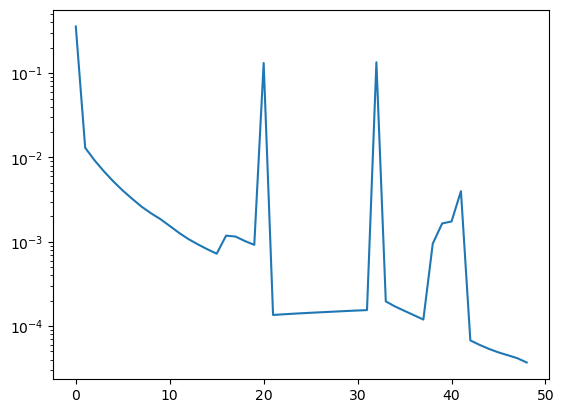

In [43]:
plt.semilogy(dArea)

In [44]:
idx = np.argmin(np.linalg.norm(out[1], axis = 1))
print(idx)

49


In [45]:
nP, M,M1M2, nOmega, W, area = intersect(my_mesh,adj_triangles, P, out[0][idx])

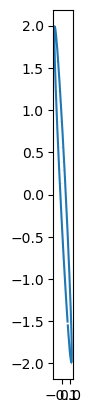

In [46]:
fig, ax = plt.subplots()

ax.plot(M[:, 1], M[:, 2])
ax.quiver(M[:, 1], M[:, 2], nOmega[:, 0], nOmega[:, 2])
ax.quiver(P[1], P[2], W[1], W[2], color = "rebeccapurple",  width=0.005, headwidth= 1.5, headlength = 5)
ax.set_aspect("equal")

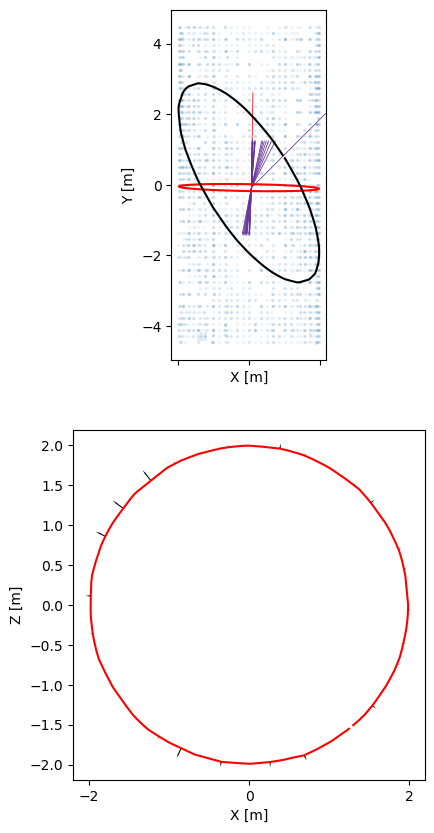

In [47]:
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex = True)

ax.scatter(my_mesh[::2, 0], my_mesh[::2, 1], s=2, alpha = 0.05)
ax.quiver(P[0], P[1], nP[0], nP[1], color = "red", scale = 20, width=0.005, headwidth= 1.5, headlength = 5)

for n in out[0]:
    ax.quiver(P[0], P[1], n[0], n[1], color = "rebeccapurple", width=0.005, headwidth= 1.5, headlength = 5, scale = 40)

#ax.quiver(P[0], P[1], W[0], W[1], color = "rebeccapurple", width=0.005, headwidth= 1.5, headlength = 5)

ax.plot(M[:, 0], M[:, 1], color = "red")
ax.plot(M0[:, 0], M0[:, 1], color = "black")

ax.quiver(M[::5, 0], M[::5, 1], nOmega[::5, 0], nOmega[::5, 1], color = "black", scale = 4, width=0.003, headwidth= 1.5, headlength =5)
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_aspect("equal")

ax2.plot(M[:, 0], M[:, 2], color = "red")
ax2.quiver(M[::5, 0], M[::5, 2], nOmega[::5, 0], nOmega[::5, 2], color = "black", scale = 4, width=0.003, headwidth= 1.5, headlength =5)
ax2.set_aspect("equal")
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Z [m]")

plt.savefig("./PlanViewBourbier_random_section.png", dpi = 300)